<a href="https://colab.research.google.com/github/Chuguevskij/Time-series/blob/main/web_traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Packages installation
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import numpy as np
import pandas as pd
import os

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split 

### Connect to Google Disc with data

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Download data

In [6]:
# Show all file for the competition
file_loc = '/content/drive/MyDrive/ds_projects_portfolio/web_traffic_forecasting/web_traffic_data'
os.listdir(file_loc)

['sample_submission_2.csv.zip',
 'sample_submission_1.csv.zip',
 'key_2.csv.zip',
 'key_1.csv.zip',
 'train_2.csv.zip',
 'train_1.csv.zip']

In [7]:
# Download a specific file
filename = 'train_2.csv.zip'
train_df_raw = pd.read_csv(f'{os.path.join(file_loc, filename)}',
                           compression='zip')

In [8]:
train_df_raw.head(1)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0


In [11]:
# Preprocess the data to a readable format
# Preprocessing for 1 batch (100 cols) becaose of memory shortage
train_df = pd.melt(train_df_raw[list(train_df_raw.columns[-100:]) + ['Page']],
                   id_vars='Page',
                   var_name='date',
                   value_name='Visits')

train_df['date'] = train_df['date'].astype('datetime64[ns]')

train_df['weekday'] = train_df['date'].apply(lambda x: x.weekday())

In [12]:
train_df.head(3)

,Page,date,Visits,weekday
0,2NE1_zh.wikipedia.org_all-access_spider,2017-06-03,30.0,5
1,2PM_zh.wikipedia.org_all-access_spider,2017-06-03,31.0,5
2,3C_zh.wikipedia.org_all-access_spider,2017-06-03,4.0,5


### Autocorrelation description (ACF and PACF)

In [14]:
# Convert to a time series format
time_tf = train_df.groupby(['date']).agg({'Visits':'sum'}).rename(columns={'Visits':'visit'})
time_tf.head()

In [17]:
# Split the sample
train_df, test_df = train_test_split(time_tf, test_size = 0.2, shuffle=False)
print(train_df.shape, test_df.shape)

(80, 1) (20, 1)


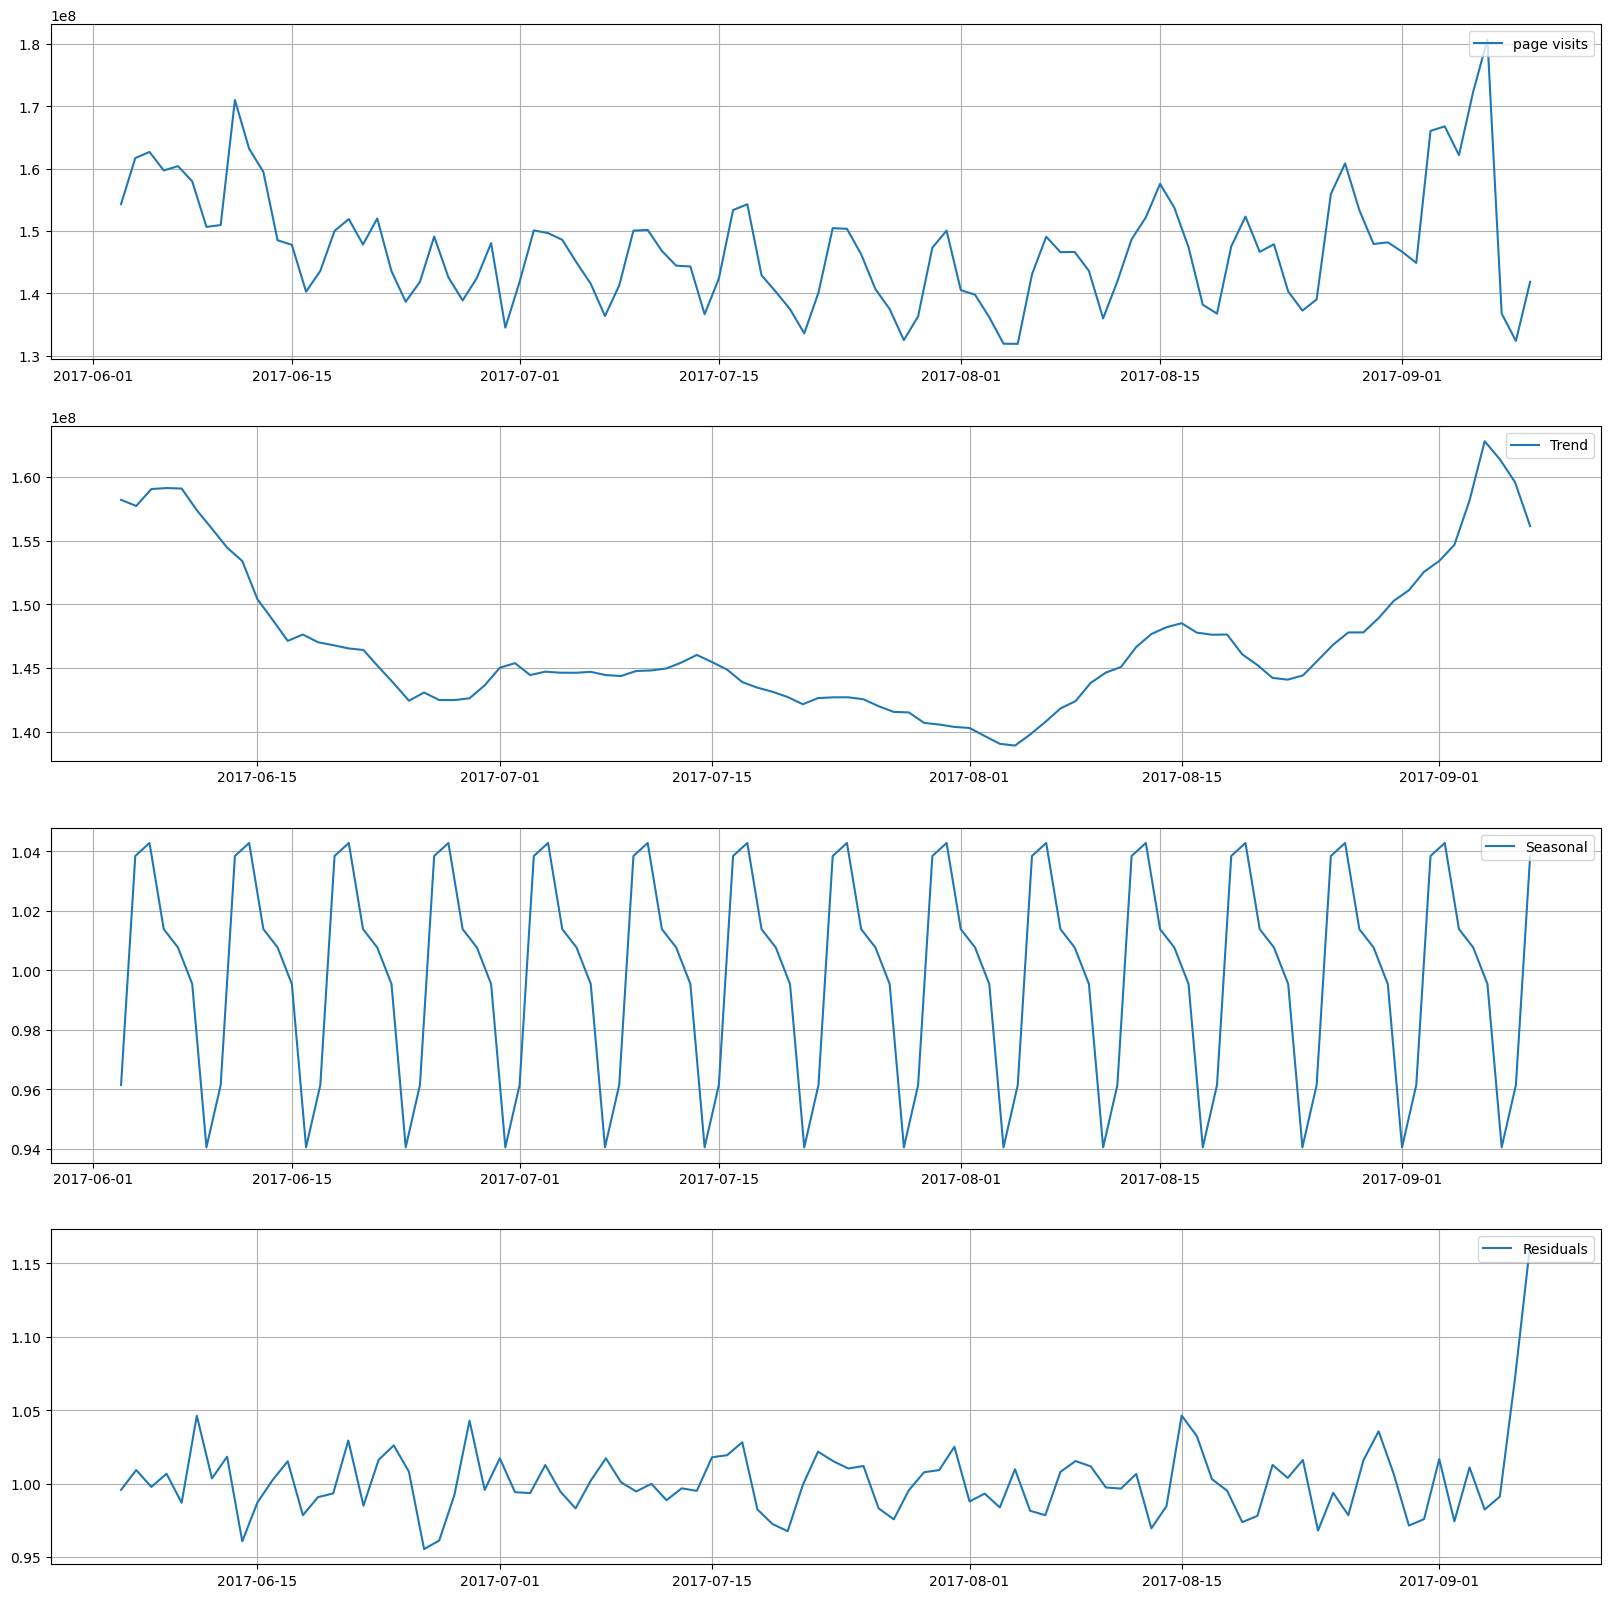

In [19]:
decomposition = sm.tsa.seasonal_decompose(time_tf, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, axes = plt.subplots(4, 1, figsize=(20, 20))
axes[0].plot(time_tf, label='page visits')
axes[0].grid()
axes[0].legend(loc='upper right')
axes[1].plot(trend, label='Trend')
axes[1].grid()
axes[1].legend(loc='upper right')
axes[2].plot(seasonal, label='Seasonal')
axes[2].grid()
axes[2].legend(loc='upper right')
axes[3].plot(residual, label='Residuals')
axes[3].grid()
axes[3].legend(loc='upper right')

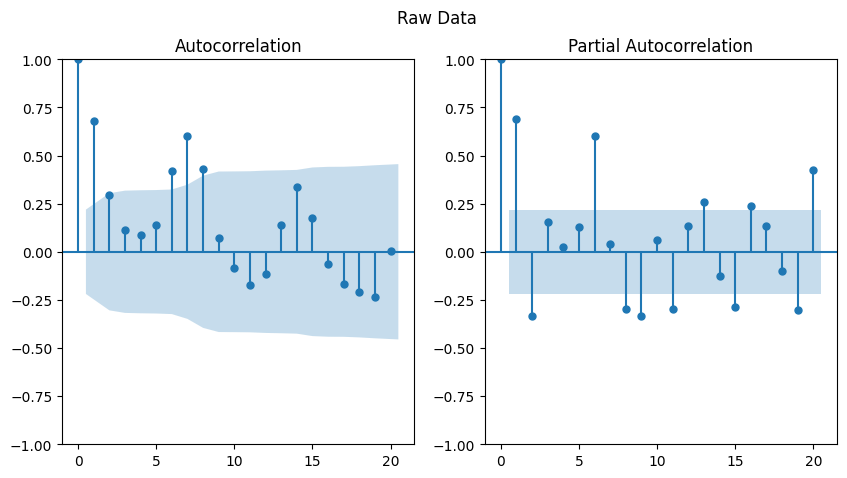

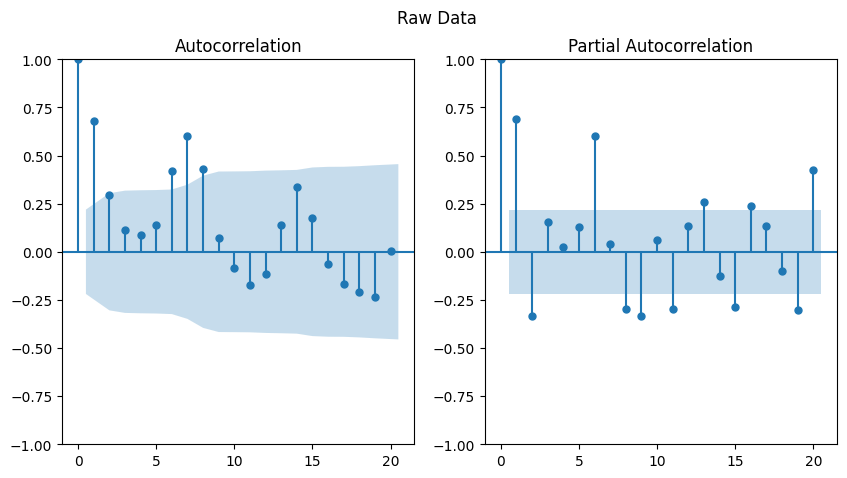

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(train_df.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_df.values.squeeze(), lags=20, ax=ax[1])

Test Statistic           -4.230540
p-value                   0.000585
Lags Used                10.000000
# of observation used    69.000000
Critical Value 1%        -3.528890
Critical Value 5%        -2.904440
Critical Value 10%       -2.589656
dtype: float64


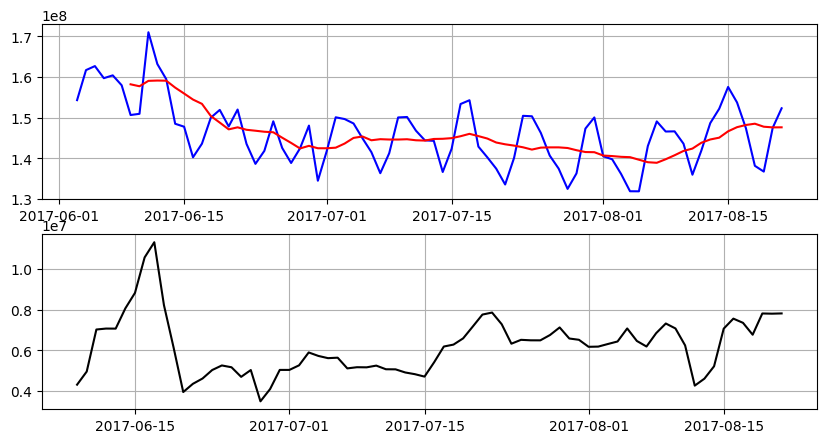

In [28]:
def test_stationary(df):
    fig, axes = plt.subplots(2, 1, figsize=(10,5))
    rolling_mean = df['visit'].rolling(7).mean()
    rolling_std = df['visit'].rolling(7).std()
    
    axes[0].plot(df['visit'], color='blue', label= 'origin')
    axes[0].plot(rolling_mean, color='red', label='Rolling Mean')
    axes[1].plot(rolling_std, color='black', label='Rolling Std')
    axes[0].grid(True)
    axes[1].grid(True)
    
    dftest = sm.tsa.adfuller(df['visit'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', '# of observation used'])
    for k, v in dftest[4].items():
        dfoutput[f'Critical Value {k}'] = v
    print(dfoutput)
    
    
test_stationary(train_df)

### ARIMA

In [33]:
model = sm.tsa.arima.ARIMA(train_df, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  visit   No. Observations:                   80
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1359.236
Date:                Tue, 04 Apr 2023   AIC                           2726.472
Time:                        15:46:01   BIC                           2735.950
Sample:                    06-03-2017   HQIC                          2730.269
                         - 08-21-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.139      4.882      0.000       0.406       0.951
ma.L1         -0.6271      0.130     -4.839      0.000      -0.881      -0.373
ma.L2         -0.0755      0.042     -1.812      0.070      -0.157       0.006
sigma2       1.85e+13   1.42e-14   1.31e+27      0.000    1.85e+13    1.85e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.68   Prob(JB):                         0.37
Heteroskedasticity (H):               0.78   Skew:                             0.36
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+43. Standard errors may be unstable.
"""